In [1]:
# Importing relevant modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform
from dynesty import NestedSampler

# Nested sampling

Nested sampling is a method for Bayesian evidence quantification that was developed by J. Skilling {cite}`skilling_nested_2006`. 
We won't look in detail at the nested sampling algorithm, however for the interested reader I suggest taking a look at the textbook published by D. S. Sivia and J. Skilling {cite}`sivia_data_2005` and the [background section of the `dynesty` package](https://dynesty.readthedocs.io/en/latest/overview.html).
Instead, this section will focusing on using the `dynesty` package to quantify the two models mentioned previously. 
Then the next section will allow you to apply this method to the interpretation of some neutron reflectometry data.

Firstly, let's get the data and models back. 

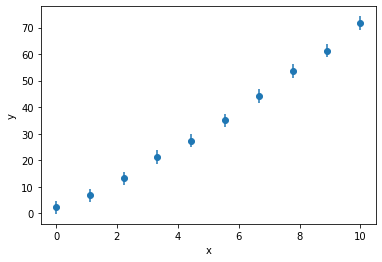

In [2]:
x, y, yerr = np.loadtxt('nested.txt', unpack=True)
plt.errorbar(x, y, yerr, marker='o', ls='')
plt.xlabel('x')
plt.ylabel('y') 
plt.show()

The potential models are either linear or quadratic:
1. $y = m x + c $ 
2. $y = ax^2 + bx + c$

In [3]:
def model1(x, m, c):
    return m * x + c

def model2(x, a, b, c):
    return a * x ** 2 + b * x + c

Now we need to create function that will return the [log-likelihood](./likelihood) for a model and a given set of parameters.

In [4]:
def loglike(p, x, y, yerr, model):
    return -0.5 * np.sum(np.square((y - model(x, *p)) / yerr) + np.log(2 * np.pi * yerr))

Since the determination of the evidence is the integral of the likelihood and the prior for each parameter, we must define these. 
These must be bounded integrals, i.e. they cannot start or end at infinity. 
For this example, uninformative priors (where all values within the bounds are equally likely) where used. 
These are define within the prior transform function below. 

In [5]:
def pt_model1(u): 
    """
    The prior transform for model one, 
    where 0<=m<10 and -5<=c<5.
    
    Args:
        u (array_like): Object to be transformed.
    
    Returns:
        (array_like): Priors.
    """
    x = np.array(u)
    x[0] = uniform.ppf(u[0], 0, 10)
    x[1] = uniform.ppf(u[1], -5, 5)
    return x 

def pt_model2(u): 
    """
    The prior transform for model two, 
    where 0<=a<1, 0<=b<10, and 0<=c<10.
    
    Args:
        u (array_like): Object to be transformed.
    
    Returns:
        (array_like): Priors.
    """
    x = np.array(u)
    x[0] = uniform.ppf(u[0], 0, 1)
    x[1] = uniform.ppf(u[1], 0, 10)
    x[2] = uniform.ppf(u[2], 0, 10)
    return x 

We can then set up the `NestedSampler`-class objects. 
Note that because the `loglike` arguments are not just the parameters being evaluated then we must include the additional arguments in the `logl_args` keyword argument.
Below, we set up the sampler for each of the two models.

In [6]:
sampler1 = NestedSampler(loglike, pt_model1, 2, logl_args=[x, y, yerr, model1])
sampler2 = NestedSampler(loglike, pt_model2, 3, logl_args=[x, y, yerr, model2])

The sampling is then performed with the `run_nested()` method. 

In [7]:
sampler1.run_nested()

iter: 2357 | +500 | bound: 2 | nc: 1 | ncall: 18858 | eff(%): 15.150 | loglstar:   -inf < -16.845 <    inf | logz: -20.698 +/-  0.102 | dlogz:  0.001 >  0.509                                        

In [8]:
sampler2.run_nested()

iter: 3452 | +500 | bound: 6 | nc: 1 | ncall: 21634 | eff(%): 18.268 | loglstar:   -inf < -14.090 <    inf | logz: -20.189 +/-  0.147 | dlogz:  0.001 >  0.509                                        

These will run until some stopping criteria is reached, by default this stopping criteria is that the change in the estimated log-evidence is less than 0.001.
We can visualise the convergence of the log-evidence by examing the `results` attribute.

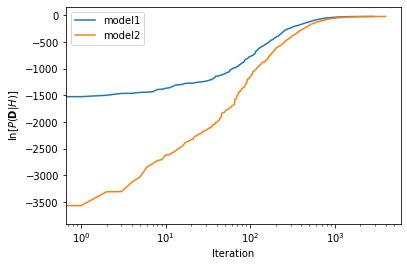

In [12]:
plt.plot(sampler1.results['logz'], label='model1')
plt.plot(sampler2.results['logz'], label='model2')
plt.legend()
plt.xscale('log')
plt.xlabel('Iteration')
plt.ylabel('$\ln[P(\mathbf{D}|H)]$')
plt.show()

The final estiamte for the log-evidence is the value that we are interested in. 

In [13]:
model1_logz = sampler1.results['logz'][-1]
model2_logz = sampler2.results['logz'][-1]